# bertrand2025/figure4
Plot figure 4 from Bertrand et al. 2025, "Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory".

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrow
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import interpolate
import statsmodels.formula.api as smf
import statsmodels.api as sm

#from load_preproc_nb40 import load_arm_temp, load_abo_temp, nanmean, load_minutely_flux_hists
from prep_basecase_nb44 import *
from analyze_by_basecase_nb48 import *

from IPython.display import display, Math

In [2]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()
#subset to DJFM
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

# 2. base cases

In [3]:
# load weights f
da_weights_djfm = xr.open_dataset('cloud_phase_monthly_frequency.nc')
da_weights_djfm = da_weights_djfm['weights']
da_weights_avg  = da_weights_djfm.mean('time')

In [4]:
# load base case specification datasets
spec_met = xr.open_dataset('46-1-base_cases_met.nc')
spec_cld = xr.open_dataset('46-1-base_cases_cld.nc')
spec = xr.merge([spec_met,spec_cld])
cloudy = xr.DataArray(data=[True,True,True,False],dims=['type'],
                      coords={'type':np.array(['liquid', 'mixed', 'ice','clear'])})
spec = spec.assign(is_cloudy=cloudy)

In [5]:
attributed_err_by_case = xr.open_dataset('drivers_by_type_error.nc')
attributed_med_by_case = xr.open_dataset('drivers_by_type.nc')
attrib_tot_med = xr.open_dataset('allsky_attributed_driving.nc')
attrib_tot_err = xr.open_dataset('allsky_attributed_driving_error.nc')

In [6]:
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

In [7]:
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

### 3.3.1 get numbers that go in the figure write-up

# 4. net longwave by cumulative drivers
Add predicted net by base case as semitransparent lines with the same color coding? Does that make any sense? I think on a basic level the stacked bar chart won't work anymore because the signs of various things will become confusing. But maybe it could work somehow. I feel like the cleanness of the four traces could work better even though the presentation is unusual.

## 4.2 LWN simple sums by base case
'Planck', 'All non-cloud', 'All', and 'total'. Should I keep the cumulative sum graphical scheme? Like 'Planck', '+ Other non-cloud' (WV, LR, CO$_2$), '+ cloud', and then 'total' or 'constraint'. And the dual y-axes? Like inferred and direct, or inferred and observed, or attributed and constraint?

In [8]:
def prepend_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_tot.assign_coords({dim:'total'}),ds_by_case],dim=dim)
def append_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_by_case,ds_tot.assign_coords({dim:'total'})],dim=dim)

In [9]:
attributed_med = xr.open_dataset('driving_by_driver.nc')
attributed_err = xr.open_dataset('drivers_by_type_error.nc')
attributed_med_by_case = xr.open_dataset('drivers_by_type.nc')
attributed_err_by_case = xr.open_dataset('drivers_by_type_error.nc')
dxdt_med = xr.open_dataset('feature_response_to_temperature.nc')
dxdt_err = xr.open_dataset('feature_response_to_temperature_error.nc')
dxdt_hi = dxdt_med + dxdt_err
dxdt_lo = dxdt_med - dxdt_err

In [10]:
attributed_med_all = append_tot(attributed_med,attrib_tot_med)
attributed_err_all = append_tot(attributed_err,attrib_tot_err)

In [11]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.7,'edgecolor':'k','linewidth':0.5}

In [12]:
ds = xr.open_dataset('fig4_data.nc')
slp = ds.press
lwn_anom = ds.lwn_anom
twp_anom = ds.twp_anom
lwp_anom = ds.lwp_anom
iwp_anom = ds.iwp_anom
tanom = ds.tanom

### data prep

In [13]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()

dp = 10 #hPa
#bins = np.arange(slp.min(),slp.mean()-dp/2,dp)
#bins = np.concatenate([bins,np.arange(slp.mean()+dp/2,slp.max(),dp)])
bins = np.arange(-30,30+dp,dp)
mids = 0.5*(bins[1:]+bins[:-1])

In [14]:
#load phase classification
def bit_packed_to_broad_categories(phases):
    '''convert bit-packed phase mask to bool for a group of bits'''
    
    #define phase categories via the flag values satisifying each category
    cloud_liquid = [3,5]              #liquid, liquid+drizzle
    cloud_mixed  = [7]                #mixed-phase
    cloud_ice    = [1,2]              #ice, snow
    phase_vars   = {'liquid': cloud_liquid,
                    'mixed': cloud_mixed,
                    'ice': cloud_ice}
    
    #get profiles satisfying broad categories specified in phase_vars
    phase_res = { }
    for name,flags in phase_vars.items():
        #convert list of flag values to int with bits on for flag values
        flag_map = bitlist_to_int(flags)
        #check if at least one of the flag values is present in profile
        flag_res = (phases&flag_map) > 0
        phase_res[name] = flag_res

    #exclude liquid-containing profiles as ice
    phase_res['ice'] = phase_res['ice'] & ~(phase_res['mixed'] | phase_res['liquid'])

    #exclude mixed-containing profiles as liquid
    phase_res['liquid'] = phase_res['liquid'] & ~phase_res['mixed']

    #return as dataset
    return xr.Dataset(phase_res)

#load column-integrated phases and convert to broad categories
folder = Path('~/Documents/arm_data/').expanduser()
fps = sorted((folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
st_prof  = xr.open_mfdataset(fps)
is_phase = st_prof.phase.compute().astype(int)
is_phase = bit_packed_to_broad_categories(is_phase)
residual = (st_prof.tot_cld>0) & ~(is_phase['liquid'] | is_phase['mixed'] | is_phase['ice'])
clear    = st_prof.tot_cld==0
is_phase = is_phase.assign({'clear':clear,'other':residual})
is_phase = is_phase.assign(all=xr.ones_like(is_phase['liquid']))
is_phase = is_phase.compute()
for name,total in is_phase.sum('time').items():
    if total == 0:
        print(f'dropping category "{name}" because it contains no observations')
        is_phase = is_phase.drop(name)
#apply layer-based screening of liquid-only cases
fps = sorted((folder/'ipynb_processed'/'59-betterliquidonly-columnint-minutely-by-year').glob('*.nc'))
is_liquid = xr.open_mfdataset(fps).compute()
is_phase['mixed']  = is_phase['mixed']  | is_liquid['liquid_snowing']
is_phase['liquid'] = is_phase['liquid'] & is_liquid['liquid_nosnow']

dropping category "other" because it contains no observations


In [15]:
def do_regression(resp_mos,tanom_mos):
    Y, X = xr.align(resp_mos.dropna('time'),tanom_mos.dropna('time'))
    Y, X = Y.data, X.data
    X = sm.add_constant(X)
    olsr_djfm_res = sm.OLS(Y,X, missing='drop').fit()
    return olsr_djfm_res

def gather_strata(resp,tanom,slp):
    reses = [ ]
    for pi,pf in zip(bins[:-1],bins[1:]):
        msk = (pi<=slp) & (slp<pf)
        resp_sub  = resp.sel(time=msk)
        tanom_sub = tanom.sel(time=msk)
        resp_mos  = resp_sub.resample(time='MS').mean()
        tanom_mos = tanom_sub.resample(time='MS').mean()
        olsr_djfm_res = do_regression(resp_mos,tanom_mos)
        reses.append(olsr_djfm_res)
    return reses

def parse_results(reses,alpha=0.05):
    slope_lo, slope_hi, slope_med = [], [], []
    for res in reses:
        slope_lo.append(res.conf_int(alpha)[1,0])
        slope_hi.append(res.conf_int(alpha)[1,1])
        slope_med.append(res.params[1])
    return np.array(slope_lo), np.array(slope_hi), np.array(slope_med)

## 5.6 Net flux, total water path

(-7.13115688292676, 27.1897099248589)


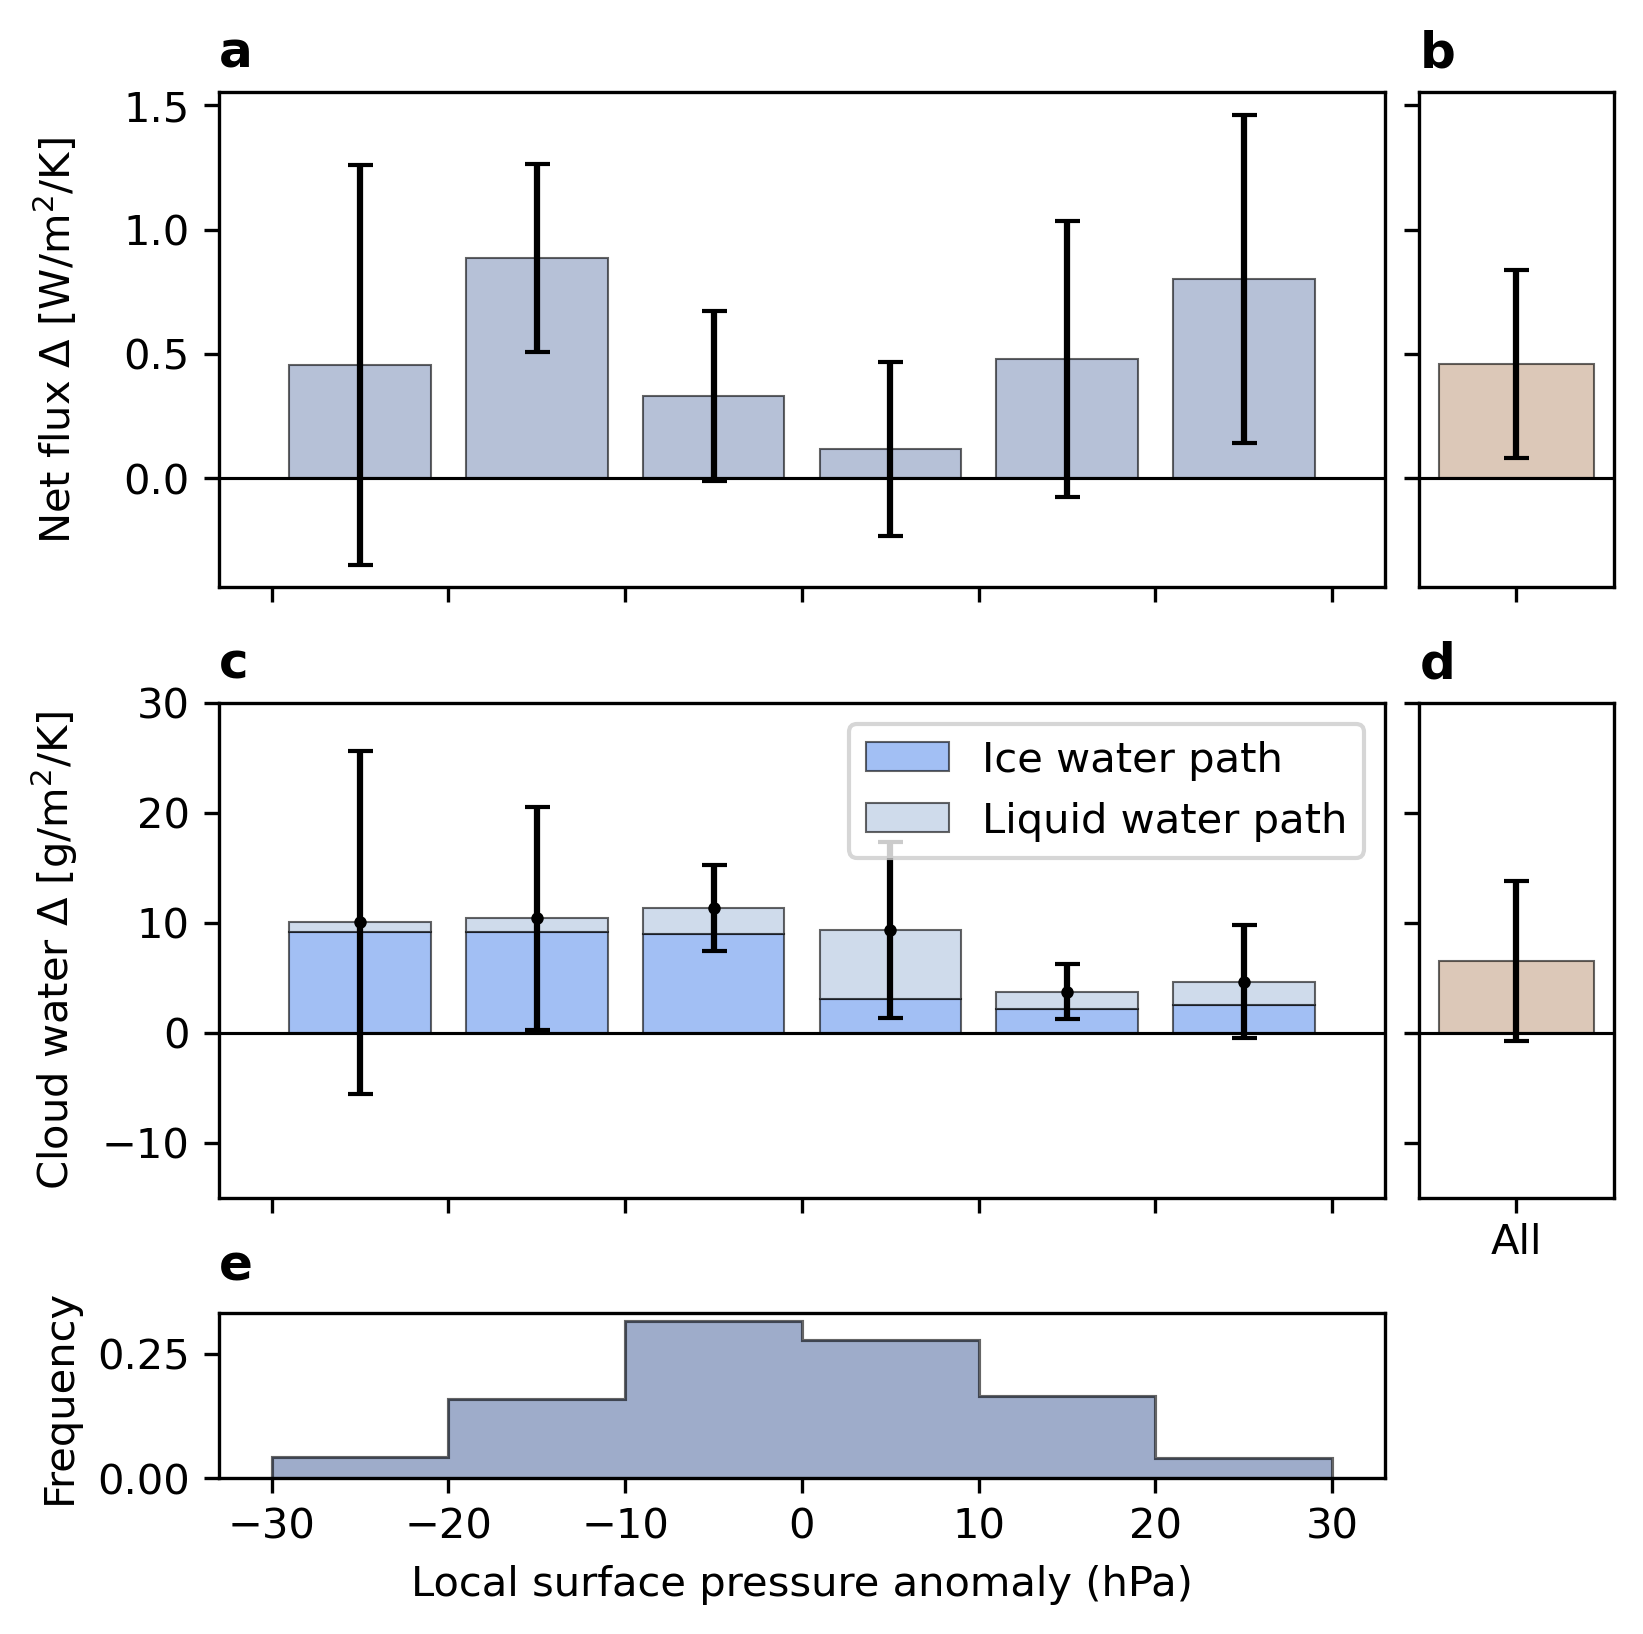

In [16]:
#errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
#clear, ice, mixed, liquid
#colors=iter(['royalblue','cornflowerblue','lightsteelblue','slategray'])
for i,resp in enumerate([lwn_anom,twp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    if ax==axes[1,0]:
        #  stacked bar
        reses_ice = gather_strata(iwp_anom, tanom, slp)
        reses_liq = gather_strata(lwp_anom, tanom, slp)
        _, _, slope_med_ice = parse_results(reses_ice,alpha=0.05)
        _, _, slope_med_liq = parse_results(reses_liq,alpha=0.05)
        scaling = slope_med/(slope_med_ice+slope_med_liq)
        slope_med_ice = slope_med_ice*scaling
        slope_med_liq = slope_med_liq*scaling
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
        ax.bar(mids,slope_med_ice,color='cornflowerblue',width=0.8*dp,label='Ice water path',**bar_kws)
        ax.bar(mids,slope_med_liq,bottom=slope_med_ice,color='lightsteelblue',width=0.8*dp,label='Liquid water path',**bar_kws)
    else:
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
        #  bar
        ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Cloud water $\Delta$ [g/m$^2$/K]')
axes[1,0].legend(loc='upper right',ncols=1)#,bbox_to_anchor=(0.565,1.0),columnspacing=1.5)
print(axes[1,0].get_ylim())
axes[1,0].set_ylim(-15,30)
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('67-stratified_regression_net_flux_and_total_water_path_nothresh.pdf',bbox_inches='tight')